# Imports

In [499]:
import time
import random
import osmnx as ox # OSMnx library for street networks using OpenStreetMap data
import numpy as np
import pandas as pd
import seaborn as sns
from enum import Enum
import matplotlib.pyplot as plt
import matplotlib.animation as animation

sns.set(
    {"figure.figsize": (17, 7)},
    style="ticks",
    palette=sns.color_palette("Set2"),
    color_codes=True,
    font_scale=0.8
)

%config InlineBackend.figure_format = "retina"

# Create graph

In [500]:
start_coords = (53.472075, -2.238855) # The Dalton Building

In [501]:
# Get data from open street maps with OSMnx
G = ox.graph_from_point(start_coords, dist=3000, network_type="drive", simplify=True)

In [502]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

# General Node Class

In [503]:
class Node():
    '''
    Generic node class to store graph nodes.

    Attributes:
        node_id: int = The node's unique id number from OSMnx
        cost_to_reach: float = 
    '''
    def __init__(self, node_id, cost_to_reach=0, parent=None):
        self.node_id = node_id
        self.cost_to_reach = cost_to_reach
        self.depth = 0
        
        self.parent = parent

    def path_to(self):
        if self.parent is None: return []
        
        return self.parent.path_to() + [self.node_id]
                
    def __str__(self):
        return f"<class Node Object>, ID: {self.node_id}"
    
    def __repr__(self):
        return f"({self.__str__()})"
    
    def __eq__(self, other):
        # Compare equality based on the node_id
        if isinstance(other, Node):
            return self.node_id == other.node_id
        return False

    def __hash__(self):
        return hash(self.node_id)

# Setup

### Setup figure and axes for drawing the graph

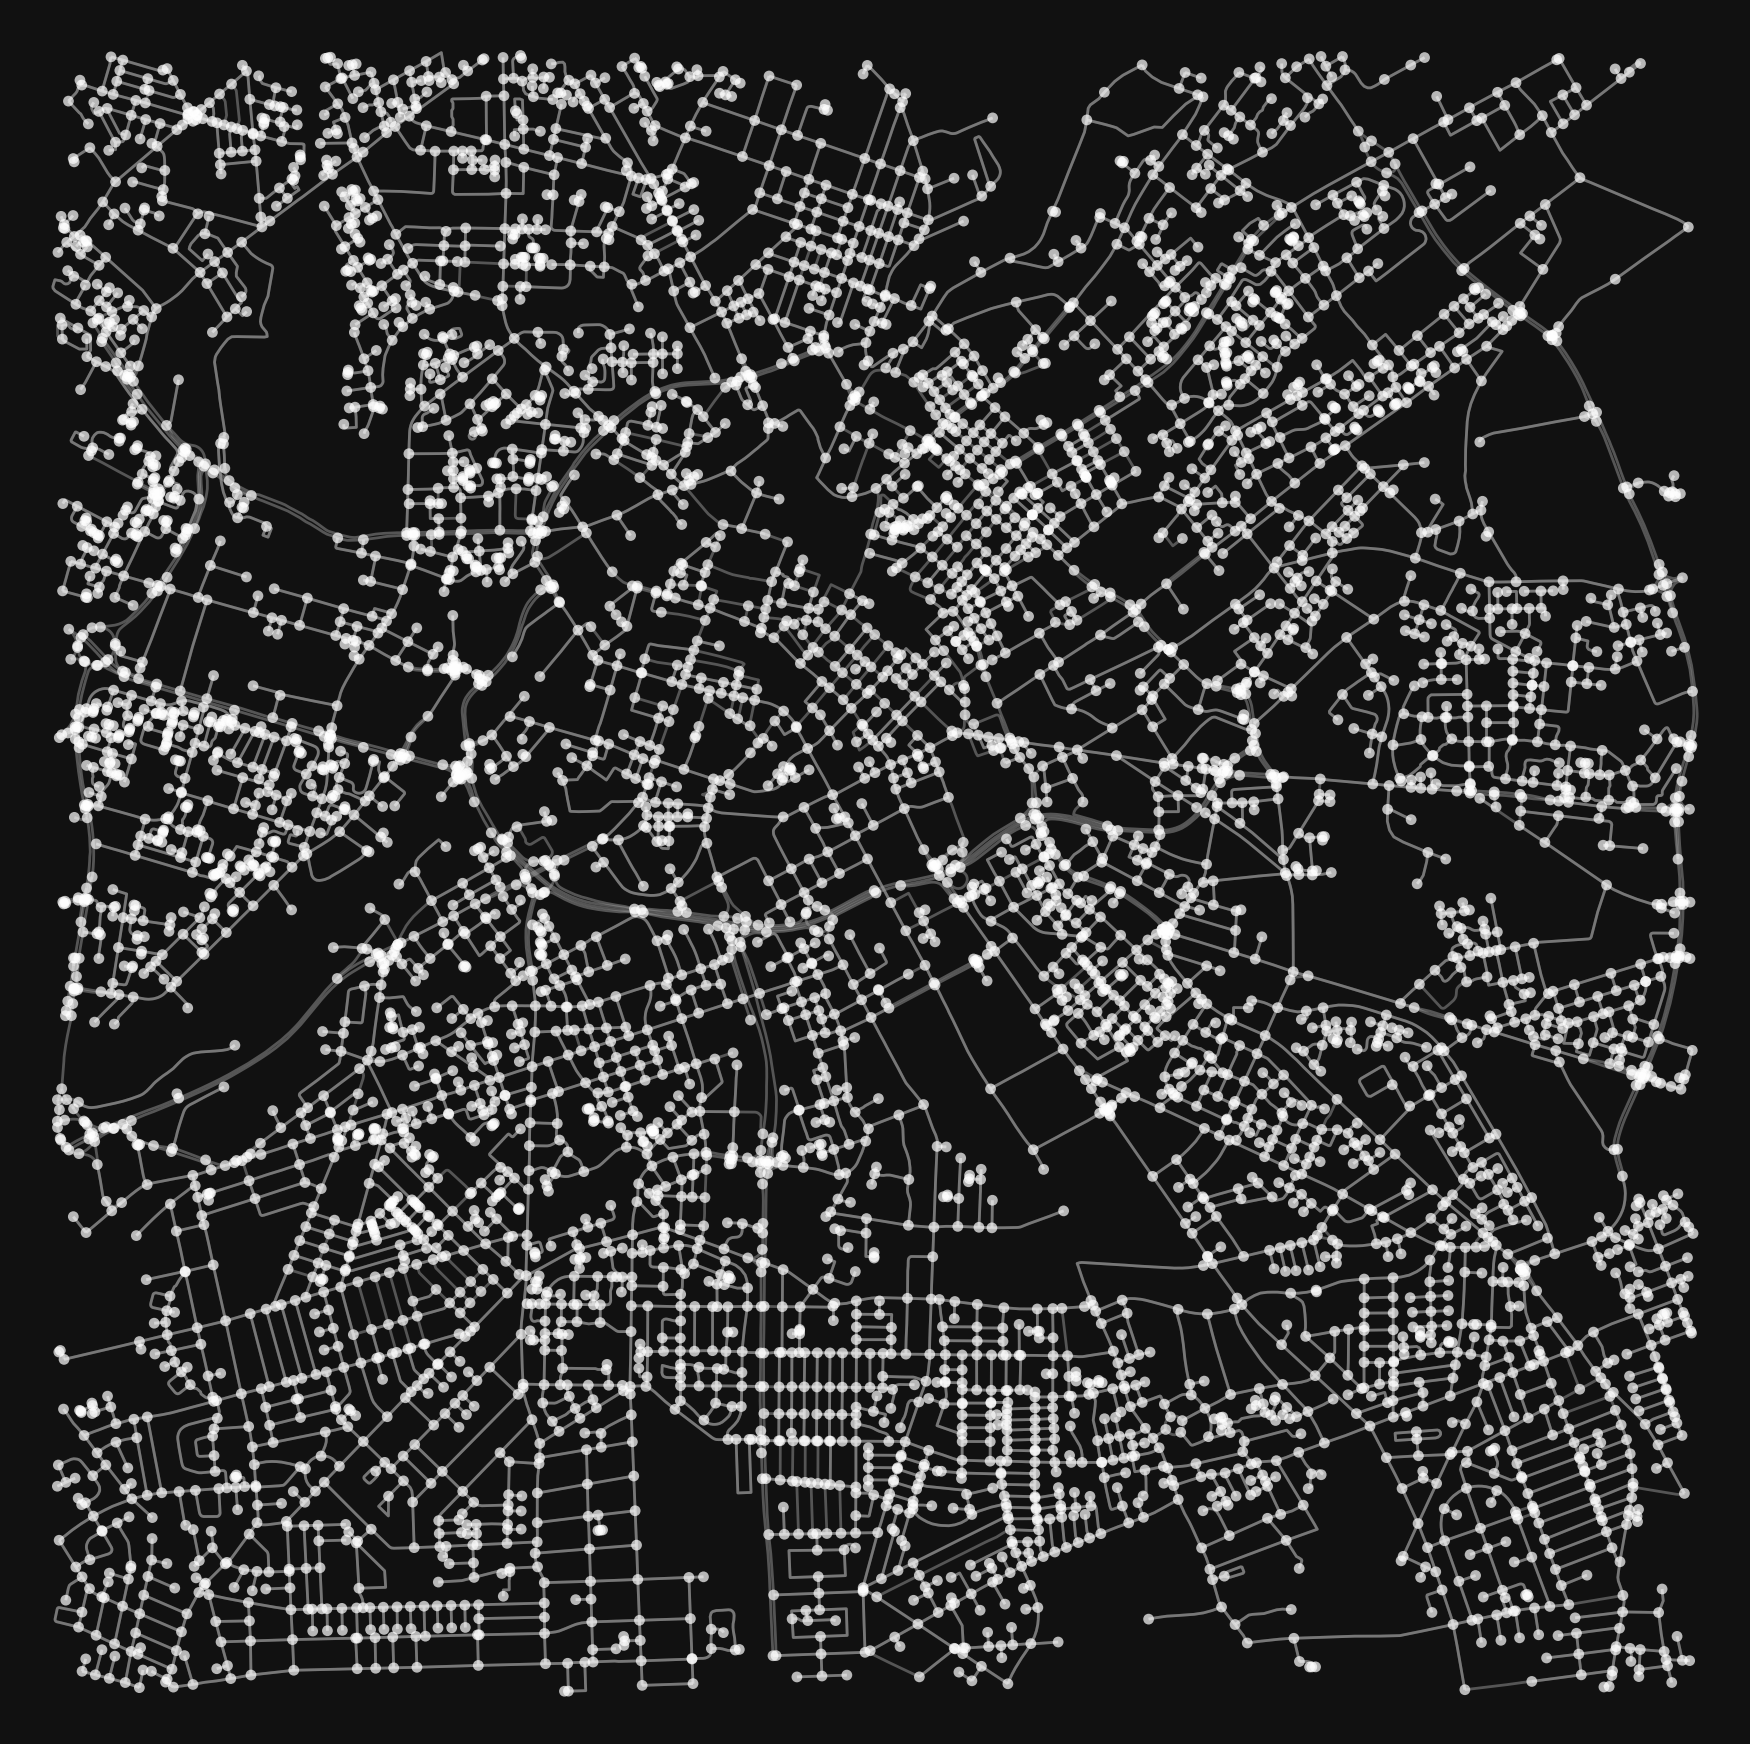

In [504]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(9, 9),facecolor="#111111");
ax.set_facecolor("#111111")

# Remove margins
ax.margins(0)
plt.tight_layout(pad=0)

fig, ax, scatter = ox.plot_graph(G, ax=ax, node_alpha=0.7, edge_alpha=0.5);

In [505]:
# Create list of nodes
nodes = [Node(node_id) for node_id in G.nodes()]
num_points = len(nodes)

In [506]:
# Create a dictionary of adjacent nodes for look-up.
adj_dict = {n: list(adjacent_node_dict.keys()) for n, adjacent_node_dict in G.adjacency()}

### Ensure all roads speeds have speeds (as floats)

In [507]:
'''
Streets speeds are strings in the format: "x mph" and some are lists of two speeds e.g. ["x mph", "y mph"]
Here these are converted to floats and the speeds are averaged when two are given. Finally any missing speeds
are filled in with the mean speed from the other roads.
'''

from sklearn.impute import SimpleImputer

def handle_maxspeed(value):
    ''' Takes a maxspeed value and converts it to a single float. '''
    if isinstance(value, str):
        # If the value is a string it splits the first part and casts it to an int
        return int(value.split()[0])
    if isinstance(value, (list, tuple)):
        # If the value is a list it splits off the first part of each, turns it into an int and returns the mean
        return np.mean([int(speed.split()[0]) for speed in value])
    if isinstance(value, (int, float)):
        return float(value)
    raise Exception(f"Unknown data type in maxspeed column: {type(value)}")

# Apply the function to the "maxspeed" column
gdf_edges["maxspeed"] = gdf_edges["maxspeed"].apply(handle_maxspeed)

imputer = SimpleImputer()
gdf_edges[["maxspeed"]] = imputer.fit_transform(gdf_edges[["maxspeed"]])

### Helper functions

In [508]:
def mph_to_mps(speed_mph):
    ''' Convert speed from mph to metres per second. '''
    return (speed_mph * 1609.344) / 60**2

def time_between(start_node_id, end_node_id):
    '''
    Locates the edge between two nodes (based on their ID) and returns the time taken to
    drive between them in seconds.
    '''
    try:
        edge_start_to_end = gdf_edges.xs(start_node_id, level="u").xs(end_node_id, level="v")
    except Exception as e:
        print(start_node_id, end_node_id)
        raise Exception(e)

    road_speed_mph = edge_start_to_end["maxspeed"][0].item()
    road_length_m = edge_start_to_end["length"][0].item()

    return road_length_m / mph_to_mps(road_speed_mph) 

def format_time(seconds):
    '''
    Converts time in seconds to a readable string in hours, minutes and seconds.
    '''
    return time.strftime("%H:%M:%S.%f", time.gmtime(seconds))

# Visualising

# Searching

In [509]:
# class syntax
class SearchType(Enum):
    BFS = 0
    DFS = 1
    UCS = 2
    A_STAR = 3

class SearchClass:
    '''
    General class for searching searching for paths between two nodes. Implements breadth-first search,
    depth-first search, uniform-cost search and A*.
    '''
    def __init__(self, start_node, destination_node, heuristic_func=None):
        self.start = start_node
        self.destination = destination_node
        self.done = False

        self.open = [start_node]
        self.closed = []

        self.current_node = start_node

        self.heuristic_dict = {start_node: heuristic_func(start_node, destination_node)} if heuristic_func is not None else {}
        self.heuristic_func = heuristic_func


    def reset(self):
        self.closed = []
        self.done = False
        self.heuristic_dict = {self.start: self.heuristic_func(self.start, self.destination)} if self.heuristic_func is not None else {}
        self.open = [self.start]
        self.current_node = self.start

    def run_search(self, search_type: SearchType, heuristic_func=None):
        if heuristic_func: self.heuristic_func = heuristic_func
        if search_type == SearchType.A_STAR and self.heuristic_func == None:
            raise Exception("Heuristic function is required to run A* search.")
        
        while not self.done:
            self.search_step(search_type=search_type)

    def search_step(self, search_type: SearchType):       
        next_node = self.pick_node(search_type)
        if self.heuristic_func is not None: self.heuristic_dict[next_node] = self.heuristic_func(next_node, self.destination)
        self.done = (next_node == self.destination) or (next_node is None)
        self.open.extend([Node(node_id, parent=next_node, cost_to_reach=(next_node.cost_to_reach + self.calc_path_time([next_node.node_id, node_id]) if search_type == SearchType.UCS else np.nan)) for node_id in adj_dict[next_node.node_id] if Node(node_id) not in self.closed])
        self.closed.append(next_node)
        self.current_node = next_node

        return next_node
    
    def pick_node(self, search_type: SearchType):
        if len(self.open) == 0:
            return None
        
        if search_type == SearchType.BFS:
            return self.open.pop(0)
        if search_type == SearchType.DFS:
            return self.open.pop(-1)
        if search_type == SearchType.UCS:
            self.open.sort(key=lambda node: node.cost_to_reach)
            return self.open.pop(0)
        if search_type == SearchType.A_STAR:
            # self.heuristic_func(node, self.destination)
            self.open.sort(key=lambda node: self.heuristic_func(node, self.destination))
            # self.open.sort(key=lambda node: self.heuristic_dict[node] if node in self.heuristic_dict.keys() else self.heuristic_func(node, self.destination))
            return self.open.pop(0)
        
    def calc_path_time(self, path):
        time = 0
        for i in range(len(path) - 1):
            time += time_between(path[i], path[i+1])
        return time
    
    def describe_path(self, path):
        path_list = []
        for i in range(len(path) - 1):
            path_list.append(str(list(gdf_edges.xs(path[i], level="u").xs(path[i + 1], level="v")["name"])[0]))
        return pd.Series(path_list).unique()

In [510]:
# Visualisation code

# Create a dictionary to map nodes to their index in a list
node_index_map = {nodes[i]: i for i in range(num_points)}

def update_graph_visuals(current_node, closed_set, destination_node):
    '''
    Function to update the sizes and colours of the nodes in the graph.
    '''
    sizes = [2 for i in range(num_points)]
    colours = ["#FFFFFF" for i in range(num_points)]
    
    # Loop through all closed (visited) nodes and set them to yellow and size 10
    for node in closed_set:
        sizes[node_index_map[node]] = 5
        colours[node_index_map[node]] = "#FFFF00"

    # Set destination node to size 30 and to purple colour 
    colours[node_index_map[destination_node]] = "#FF00FF"
    sizes[node_index_map[destination_node]] = 30
    
    # Set the current node to size 50 and to red colour
    sizes[node_index_map[current_node]] = 50
    colours[node_index_map[current_node]] = "#FF0000"
    
    # Update the sizes and colours of the nodes in the scatter plot.
    scatter.set_sizes(sizes)
    scatter.set_color(colours)

    return scatter

class SearchClass(SearchClass):
    def animate_search(self, search_type):
        # Animation function
        def animate(frame):
            next_node = self.search_step(search_type)
            update_graph_visuals(next_node, self.closed, self.destination)
            return scatter
        
        # Frame generator: Stops yielding when .done
        def frame_generator():
            frame = 0
            while not self.done:
                yield frame
                frame += 1

        # Plot the start and destination nodes
        ax.scatter(
            [G.nodes[self.start.node_id]['x'], G.nodes[self.destination.node_id]['x']],  # x-coordinates
            [G.nodes[self.start.node_id]['y'], G.nodes[self.destination.node_id]['y']],  # y-coordinates
            s=[10, 30],  # Sizes: Larger for start, smaller for destination
            c=["#00FF00", "#FF00FF"],  # Colors: Green for start, purple for destination
            zorder=3  # Ensure this is drawn on top
        )

        # Create the animation using the generator
        ani = animation.FuncAnimation(fig, animate, frames=frame_generator, interval=1, save_count=num_points)

        # Save the animation
        ffmpeg_writer = animation.FFMpegWriter(fps=5)
        print(f"Saving output to {search_type.name + "_manchester.mp4"}.")
        ani.save(search_type.name + "_manchester.mp4", writer=ffmpeg_writer)

    def display_final(self):
        if len(self.closed) <= 0:
            raise Exception("Must execute run_search method before displaying.")
        
        path = self.closed[-1].path_to()
        print("Final path:", self.describe_path(path))
        print(f"Path travel time: {format_time(self.calc_path_time(path))}s.")
    
        # Get node coordinates from the graph
        node_x = [G.nodes[node.node_id]['x'] for node in nodes]
        node_y = [G.nodes[node.node_id]['y'] for node in nodes]

        # Set default sizes and colors
        sizes = [2 for _ in range(num_points)]
        colours = ["#DDDDDD" for _ in range(num_points)] 

        # Extract start and destination node positions
        start_x, start_y = G.nodes[self.start.node_id]['x'], G.nodes[self.start.node_id]['y']
        dest_x, dest_y = G.nodes[self.destination.node_id]['x'], G.nodes[self.destination.node_id]['y']

        # Create the figure and axis
        fig, ax = plt.subplots(figsize=(8,8), facecolor="#111111")
        ax.set_facecolor("#111111")
        ax.axis('off')
        
        # Remove margins
        ax.margins(0)
        plt.tight_layout(pad=0)

        # Plot all edges (graph edges) in grey
        for u, v, data in G.edges(data=True):
            x_coords = [G.nodes[u]['x'], G.nodes[v]['x']]
            y_coords = [G.nodes[u]['y'], G.nodes[v]['y']]
            ax.plot(x_coords, y_coords, color="#777777", alpha=1, lw=1, zorder=1)

        # Highlight path edges
        full_path = [self.start.node_id] + path  # Include start node explicitly
        for i in range(len(full_path) - 1):  # Iterate through consecutive nodes in the path
            u, v = full_path[i], full_path[i + 1]
            x_coords = [G.nodes[u]['x'], G.nodes[v]['x']]
            y_coords = [G.nodes[u]['y'], G.nodes[v]['y']]
            ax.plot(x_coords, y_coords, color="#FFFF00", lw=2, alpha=1, zorder=3)  # Highlighted path edges

        # Plot all other nodes with default sizes and colors
        ax.scatter(node_x, node_y, s=sizes, c=colours, zorder=2)

        # Plot nodes on the path
        for node_id in path:
            x, y = G.nodes[node_id]['x'], G.nodes[node_id]['y']
            ax.scatter(x, y, s=6, c="#FFFF00", zorder=4)

        # Plot the start node on top (in red)
        ax.scatter(start_x, start_y, s=50, c="#FF0000", label="Start", zorder=5)

        # Plot the destination node on top (in purple)
        ax.scatter(dest_x, dest_y, s=50, c="#FF00FF", label="Destination", zorder=5)

        # Add legend for clarity
        ax.legend(facecolor="#222222", labelcolor="#FFFFFF", loc="upper right")

        plt.show()

# Heuristics

In [511]:
def euclid_distance(start_node, end_node):
    x_start, y_start = G.nodes[start_node.node_id]['x'], G.nodes[start_node.node_id]['y']
    x_end, y_end = G.nodes[end_node.node_id]['x'], G.nodes[end_node.node_id]['y']

    return ((x_start - x_end)**2 + (y_start - y_end)**2)**0.5

def manhattan_distance(start_node, end_node):
    '''
    Manhattan distance is not an admissible heuristic in the context of driving as roads can have different speed limits
    which means a node may be given a large heuristic value as it is far from the target but it may be a fast road and thus
    the heuristic will overestimate the true cost.        
    '''
    x_start, y_start = G.nodes[start_node.node_id]['x'], G.nodes[start_node.node_id]['y']
    x_end, y_end = G.nodes[end_node.node_id]['x'], G.nodes[end_node.node_id]['y']

    return abs(x_start - x_end) + abs(y_start - y_end)

def distance_normalised(start_node, end_node):
    '''
    A admissible heuristic can be created by dividing the straight-line distance to the goal by the maximum speed on the roads.
    This ensures that the heuristic is maximally optimistic i.e. assuming the car travels directly at max speed to the goal.
    With an optimistic heuristic like this the cost will never be overestimated.
    '''
    return euclid_distance(start_node, end_node) / gdf_edges["maxspeed"].max()

# Running

In [512]:
# Start at the Dalton Building
start_node = Node(ox.distance.nearest_nodes(G, Y=start_coords[0], X=start_coords[1]), cost_to_reach=0)

# Random destination
destination_node = random.choice(nodes)

searcher = SearchClass(start_node, destination_node, heuristic_func=distance_normalised)

In [513]:
# Run a search with each algorithm

for method in SearchType:
    print(f"Searching with {method.name}...")
    searcher.reset()

    start_time = time.time()
    searcher.run_search(search_type=method)
    
    print(f"{method.name} search took {format_time(time.time() - start_time)}s.")
    searcher.display_final()

In [514]:
for method in SearchType:
    searcher.reset()
    searcher.animate_search(search_type=method)

Saving output to A_STAR_manchester.mp4.


<div style="display: flex;">
  <div style="flex: 50%;">
        <h1>Breadth First
        <br>
        <video src="bfs_manchester.mp4" alt="bfs" width="501" controls/>
    </div>

  <div style="flex: 50%;">
        <h1>Depth First
        <br>
        <video src="dfs_manchester.mp4" alt="dfs" width="501" controls/>
    </div>
</div>

<div style="display: flex;">
  <div style="flex: 50%;">
        <h1>UCS
        <br>
        <video src="UCS_manchester.mp4" alt="bfs" width="500" controls/>
    </div>

  <div style="flex: 50%;">
        <h1>A*
        <br>
        <video src="a_star_manchester.mp4" alt="dfs" width="501" controls/>
    </div>
</div>

In [515]:
raise Exception("Stop")

Exception: Stop

# Evaluation

In [ ]:
from pretty_progress import progress_bar

n_trials = 1

results_df = pd.DataFrame({
    "Distance": np.zeros(n_trials),
    "DFS_Time": np.zeros(n_trials),
    "BFS_Time": np.zeros(n_trials),
    "A_Star_Time": np.zeros(n_trials),
    "DFS_Journey_Time": np.zeros(n_trials),
    "BFS_Journey_Time": np.zeros(n_trials),
    "A_Star_Journey_Time": np.zeros(n_trials),
})

# Run the search n times
for i in range(n_trials):
    progress_bar(i, n_trials)

    start = start_node
    end = random.choice(nodes)

    searcher = SearchClass(start_node, end, heuristic_func=manhattan_distance)

    start_time = time.time_ns()
    searcher.run_search(search_type=SearchType.BFS)
    bfs_duration =  time.time_ns() - start_time
    bfs_journey_time = searcher.calc_path_time(searcher.closed[-1].path_to())

    searcher.reset()
    start_time = time.time_ns()
    searcher.run_search(search_type=SearchType.DFS)
    dfs_duration = time.time_ns() - start_time
    dfs_journey_time = searcher.calc_path_time(searcher.closed[-1].path_to())

    searcher.reset()
    start_time = time.time_ns()
    searcher.run_search(search_type=SearchType.A_STAR)
    a_star_duration = time.time_ns() - start_time
    a_star_journey_time = searcher.calc_path_time(searcher.closed[-1].path_to())

    # Fill row
    results_df.loc[i] = [euclid_distance(start, end), dfs_duration / 1e6, bfs_duration / 1e6, a_star_duration / 1e6, dfs_journey_time, bfs_journey_time, a_star_journey_time]

|--------------------------------------------------| 0%


Done!


KeyboardInterrupt: 

In [2635]:
results_df.describe()

,Distance,DFS_Time,BFS_Time,A_Star_Time,DFS_Journey_Time,BFS_Journey_Time,A_Star_Journey_Time
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.018089,462.781360,10828.482280,1.879830,3249.763389,220.862901,229.870679
std,0.007323,496.799273,11892.253227,2.004591,1371.150590,92.637080,97.243599
min,0.001934,0.008000,0.027000,0.013000,0.000000,0.000000,0.000000
25%,0.012924,39.848250,327.967500,0.557000,2124.941689,166.745151,151.795656
50%,0.017577,312.841000,6647.809000,1.145000,3703.763577,219.327128,246.964052
75%,0.023938,776.087250,20910.708250,2.402500,4419.443959,279.896577,298.408518
max,0.034580,2035.562000,37663.024000,9.450000,4840.833138,423.304324,449.814293


In [2634]:
results_df.describe()[["DFS_Time", "BFS_Time", "A_Star_Time"]].loc["mean"]

DFS_Time         462.78136
BFS_Time       10828.48228
A_Star_Time        1.87983
Name: mean, dtype: float64

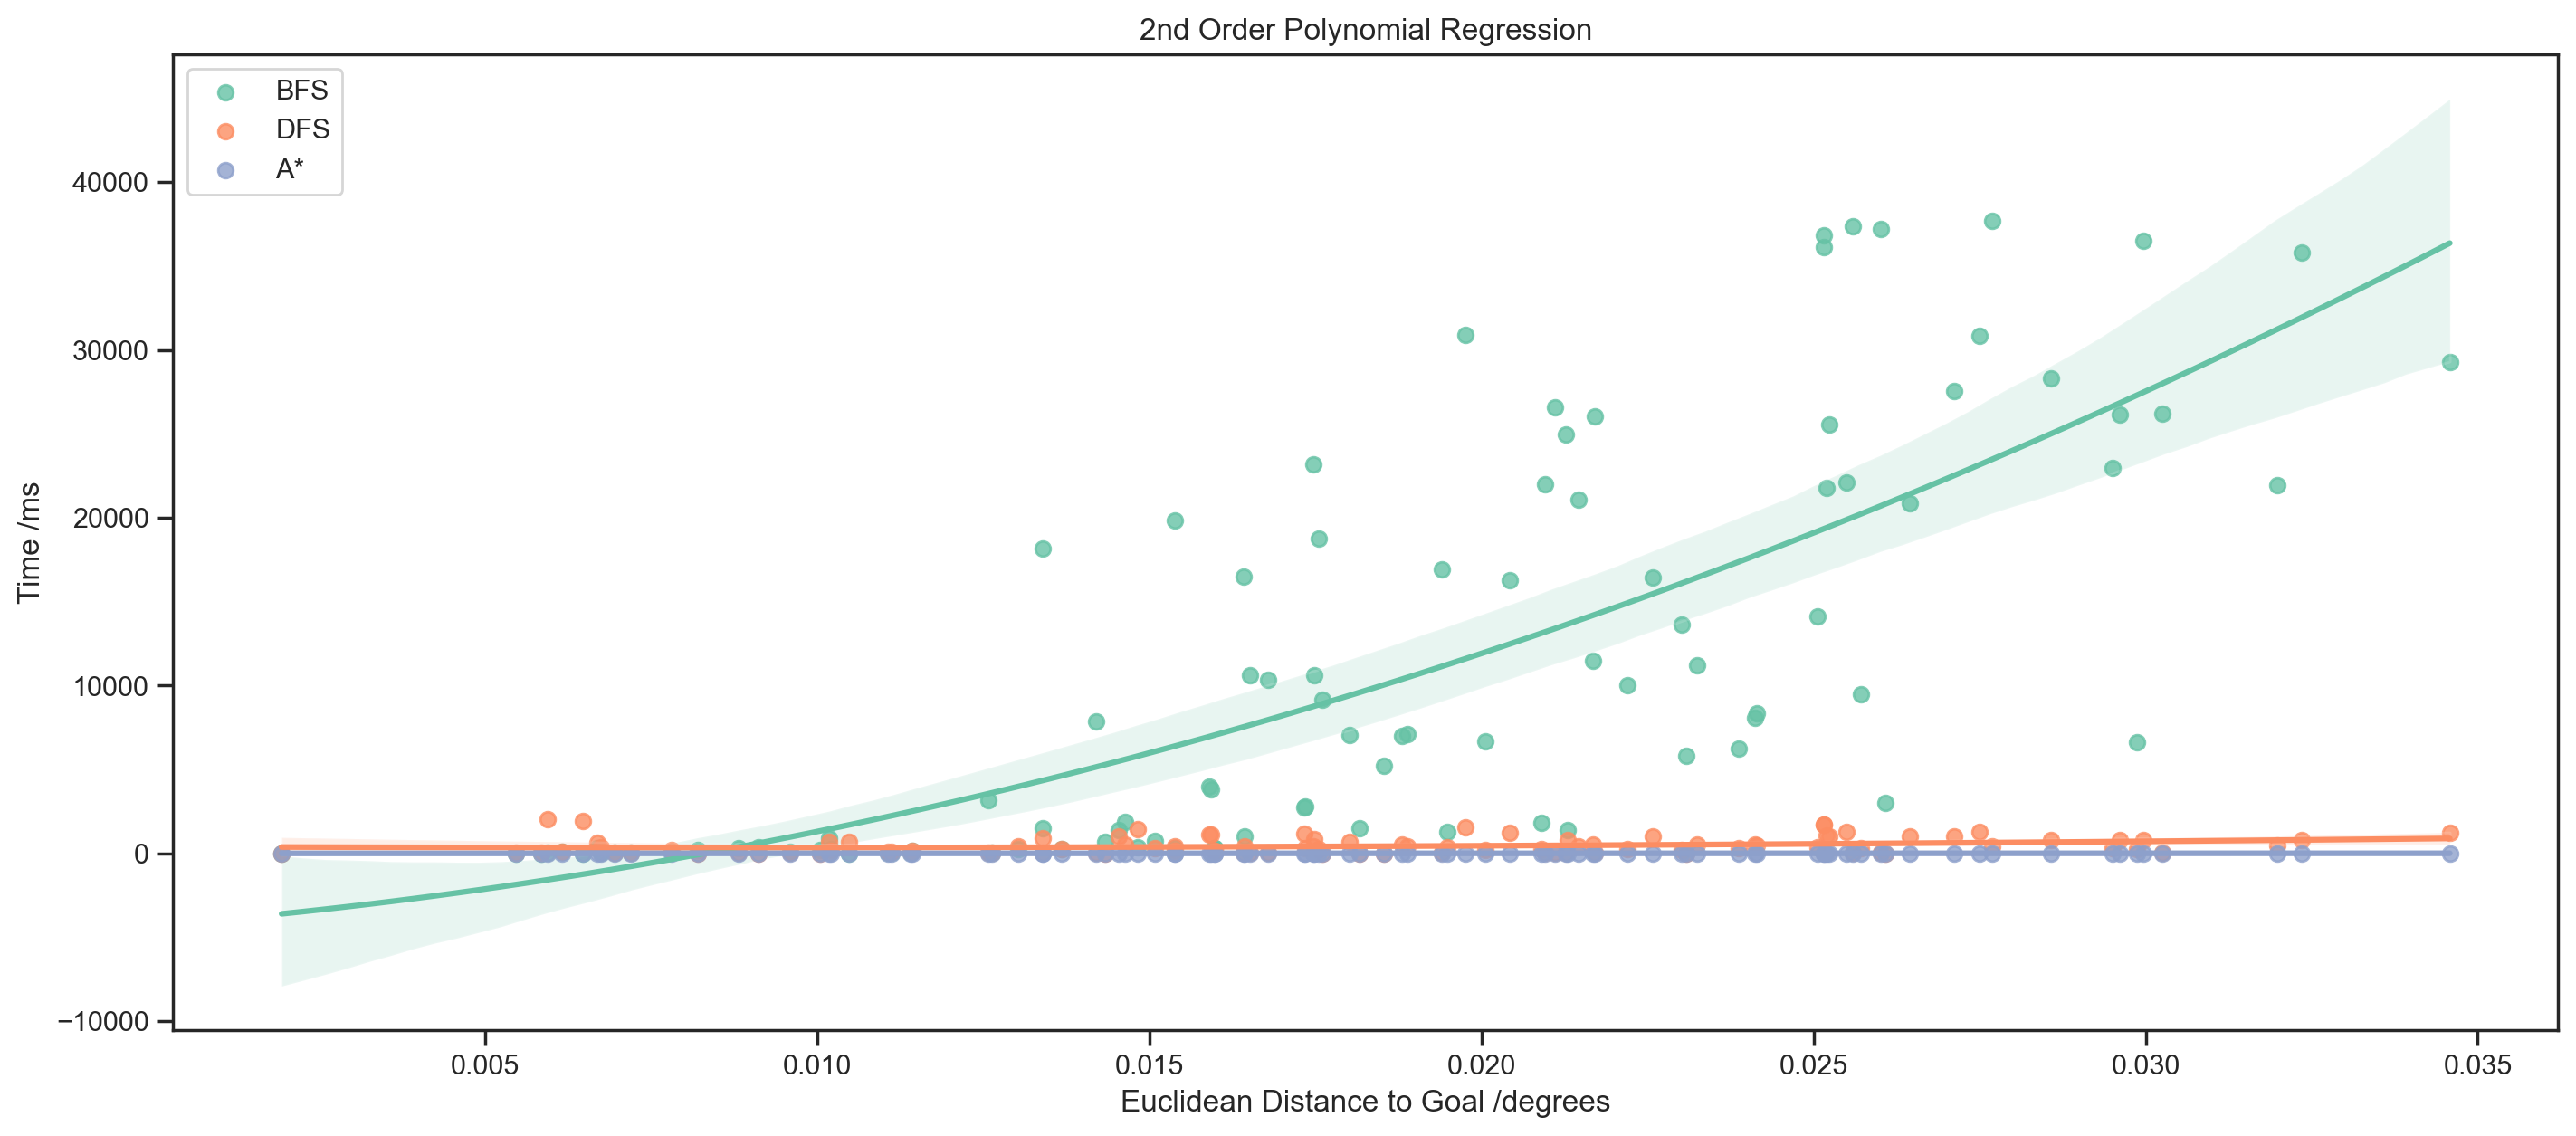

In [ ]:
sns.regplot(results_df, x="Distance", y="BFS_Time", order=2, ci=95, label="BFS")
sns.regplot(results_df, x="Distance", y="DFS_Time", order=2, ci=95, label="DFS")
sns.regplot(results_df, x="Distance", y="A_Star_Time", order=2, ci=95, label="A*")

# Customize the plot
plt.xlabel("Euclidean Distance to Goal /degrees")
plt.ylabel("Time /ms")
plt.title("2nd Order Polynomial Regression")
plt.legend()
plt.show()